# AFM DT microscope: basic functionality

This notebook provides examples of experiment simulations using the digital twin of the Atomic Force Microscope.

In [1]:
import numpy as np

import SciFiReaders
import sidpy

import h5py
import os
import sys
import warnings

warnings.filterwarnings('ignore', category=FutureWarning, module='pyNSID')

sys.path.insert(0, '/Users/borisslautin/Documents/GitHub/DTMicroscope')
import DTMicroscope
from DTMicroscope.base.afm import AFM_Microscope as AFM
from DTMicroscope.base.afm_artefacts import *

import matplotlib.pyplot as plt

from IPython.display import clear_output, display
%matplotlib inline

You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.


### 1. Initiate microscope, load dataset 

In [2]:
#initialize microscope
m = AFM(data_path = r'/Users/borisslautin/Documents/GitHub/DTMicroscope/DTMicroscope/test/datasets/dset_spm1.h5')

In [4]:
m.data_dict.keys()

dict_keys(['Channel_000', 'Channel_001', 'Channel_002', 'Channel_003', 'Channel_004', 'Channel_005', 'Channel_006'])

In [5]:
# 'data_source' refers to the path of the pre-configured dataset
m.setup_microscope(data_source = 'Compound_Dataset_1', dset_subset = 'image_dataset_0')#upload dataset?

finished processing dataset


In [6]:
m.data_dict;

In [7]:
#general information about the uploaded dataset
m.get_dataset_info()

[('channels',
  ['Channel_000',
   'Channel_001',
   'Channel_002',
   'Channel_003',
   'Channel_004',
   'Channel_005',
   'Channel_006']),
 ('signals',
  ['HeightRetrace',
   'Amplitude1Retrace',
   'Amplitude2Retrace',
   'Phase1Retrace',
   'Phase2Retrace',
   'FrequencyRetrace',
   'Response']),
 ('units', ['m', 'm', 'm', 'deg', 'deg', 'm', 'a.u.']),
 ('scans', [0, 1, 2, 3, 4, 5]),
 ('spectra', []),
 ('point_clouds', [6])]

In [8]:
#current probe position
print(f'Current location: {m.x, m.y}')

Current location: (9.803921568627648e-09, 9.803921568627648e-09)


### 2. Get scan data

You can choose the chatels you need to return by the 'channels' attribute. 

In [9]:
# The required channels can be specified using either the 'signal' or 'channels' values (see above).
dat = m.get_scan(channels=['HeightRetrace','Phase2Retrace'])

In [10]:
#dat is the 3D array (channels, y, x). Channels correspond to those selected фищму 
dat.shape

(2, 256, 256)

Text(0.5, 1.0, 'Phase2Retrace')

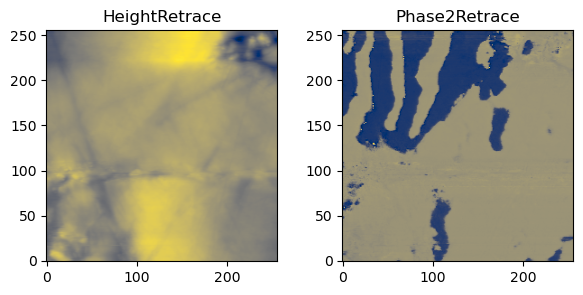

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].imshow(dat[0].T, cmap='cividis', origin='lower')
ax[0].set_title('HeightRetrace')
ax[1].imshow(dat[1].T, cmap='cividis', origin='lower')
ax[1].set_title('Phase2Retrace')

### 3. Scanning emulator

Line 255


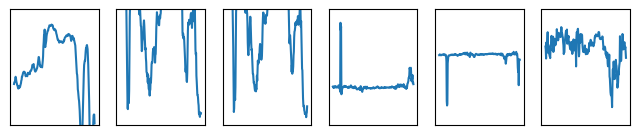

Finished scanning


In [13]:
gen = m.scanning_emulator(scan_rate=0.5)
k = 0

print(f'Line {k}')
line = next(gen)
fig, ax = plt.subplots(1, len(line), figsize=(8,1.5))
for i, ax_ in enumerate(ax):
    ax_.plot(np.arange(len(line[i])), line[i])
    ax_.set_xticks([])
    ax_.set_yticks([])
plt.ion()  # Enable interactive mode
plt.show()
k += 1

while True:  
    try:
        line = next(gen)
    except StopIteration:
        print("Finished scanning")
        break
        
    for i, ax_ in enumerate(ax):
        ax_.lines[0].set_data(np.arange(len(line[i])), line[i])
    
    clear_output(wait=True)
    print(f'Line {k}')
    display(fig)
    
    k += 1

### 4. Get individual line

In [16]:
line = m.scan_individual_line('vertical', coord = -1, channels=['Amplitude1Retrace', 'Channel_004'])

Text(0.5, 1.0, 'Channel_3')

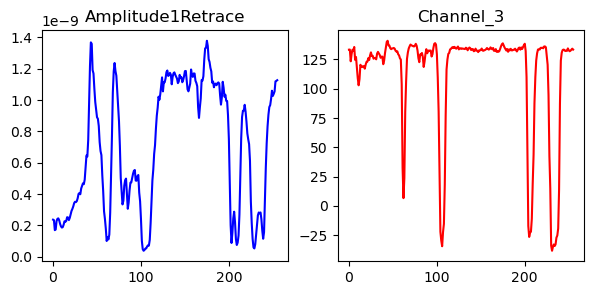

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].plot(line[0].T, color='b')
ax[0].set_title('Amplitude1Retrace')
ax[1].plot(line[1].T, color='r')
ax[1].set_title('Channel_3')

In [18]:
#print current probe position
print(f'Current location: {m.x, m.y}')

Current location: (-2.5e-06, -2.5e-06)


The current location to the tip corresponds to the ending point of the selected operation (scan, get individual line, etc.)

### 5. Scan arbitrary bath

In [19]:
corners = np.array([[-2e-6,2e-6],[1e-6,1.8e-6],[2.1e-6,0e-6]]) #real coordinates
dat = m.get_scan(channels=['Amplitude1Retrace',])

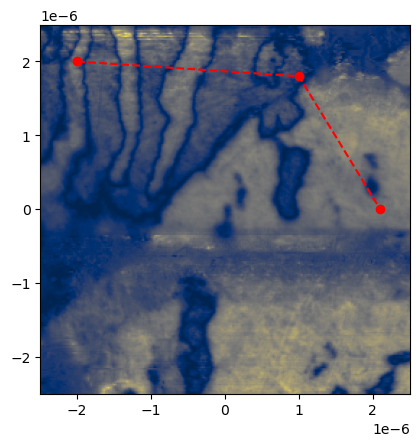

In [20]:
plt.imshow(dat[0].T, origin='lower', extent=(m.x_min, m.x_max, m.y_min, m.y_max), cmap='cividis')
plt.scatter(corners[:,0], corners[:,1], color='red')
plt.plot(*corners.T, '--', color='red')

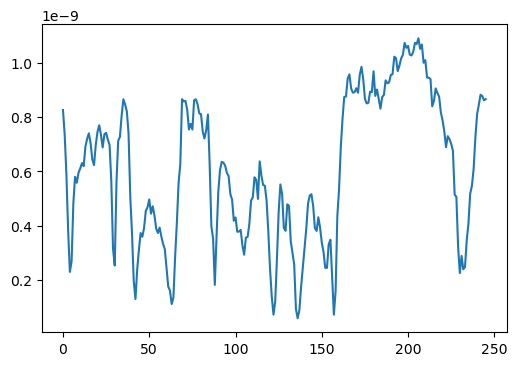

In [21]:
line = m.scan_arbitrary_path(path_points = corners, channels=['Amplitude1Retrace'])

fig = plt.figure(figsize=(6,4))
plt.plot(line[0])

### 6. Get spectral data

Get spectrum in the current probe position

In [22]:
print(f'Current position: {m.x, m.y}')

Current position: (-2.5e-06, -2.5e-06)


finished processing dataset


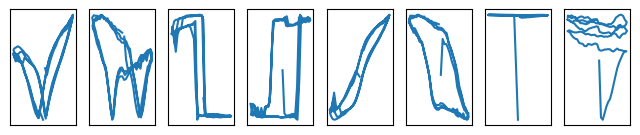

In [23]:
#We need to switch from the image to the spectral dataset for this

m.setup_microscope(data_source = 'Compound_Dataset_1', dset_subset = 'spectral_dataset_0')

res = m.get_spectrum()

fig, ax = plt.subplots(1, len(res[1]), figsize=(8, 1.5))
for i in range(len(res[1])):
    ax[i].plot(res[0], res[1][i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

In [24]:
m.go_to(0, 1e-6)

True

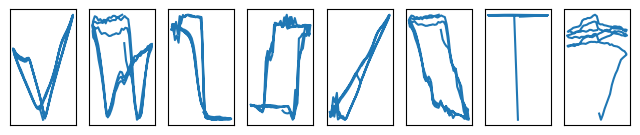

In [25]:
res = m.get_spectrum()

fig, ax = plt.subplots(1, len(res[1]), figsize=(8, 1.5))
for i in range(len(res[1])):
    ax[i].plot(res[0], res[1][i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])


## 7. Corrupted scans

### 7.1 Real tip (blunt tip)

In [26]:
#Let's go back to the image data
m.setup_microscope(data_source = 'Compound_Dataset_1', dset_subset = 'image_dataset_0')

kwargs = {'r_tip': 0.5, 'center': np.array([0.5, 0.5])}

mod_dict = [{'effect': 'real_tip', 'kwargs': kwargs},]

dat =  m.get_scan(channels=['HeightRetrace',], modification=None)
dat0 =  m.get_scan(channels=['HeightRetrace',], modification=mod_dict)
dat0.shape

finished processing dataset


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(1, 256, 256)

Text(0.5, 1.0, 'Blunt tip')

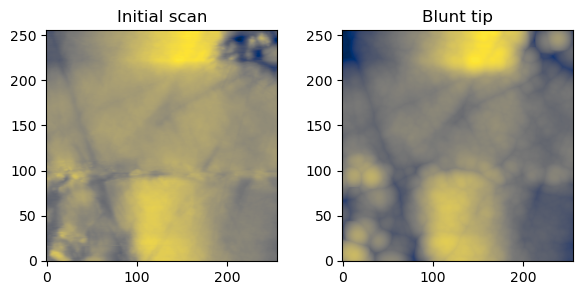

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].imshow(dat[0].T, cmap='cividis', origin='lower')
ax[0].set_title('Initial scan')
ax[1].imshow(dat0[0].T, cmap='cividis', origin='lower')
ax[1].set_title('Blunt tip')

In [28]:
#get individual line
kwargs = {'r_tip': 0.5, 'center': np.array([0.5, 0.5])}

mod_dict = [{'effect': 'real_tip', 'kwargs': kwargs},]

line =  m.scan_individual_line('vertical', channels=['Amplitude1Retrace'], coord = -1e-6, modification=None)
line1 =  m.scan_individual_line('vertical', channels=['Amplitude1Retrace'],coord = -1e-6, modification=mod_dict)
line1.shape

(1, 256)

Text(0.5, 1.0, 'Tip doubling')

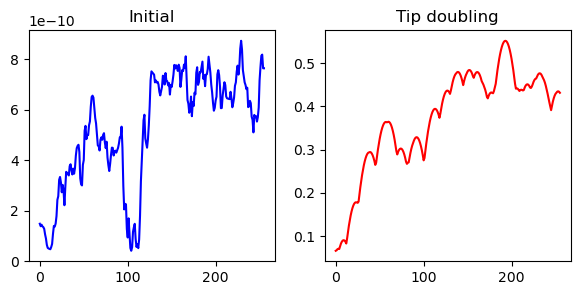

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].plot(line[0], color='b')
ax[0].set_title('Initial')
ax[1].plot(line1[0], color='r')
ax[1].set_title('Tip doubling')

### Tip doubling

In [30]:
kwargs = {'r_tip': [0.1, 0.05], 'center': [[0.2, 0.5], [0.6, 0.55]], 'length_coef': [1, 0.8]}

mod_dict = [{'effect': 'tip_doubling', 'kwargs': kwargs},]

dat =  m.get_scan(channels=['HeightRetrace',], modification=None)
dat0 =  m.get_scan(channels=['HeightRetrace',], modification=mod_dict)
dat0.shape

(1, 256, 256)

Text(0.5, 1.0, 'Tip doubling')

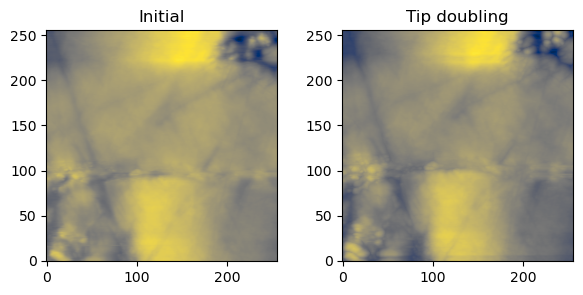

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].imshow(dat[0].T, cmap='cividis', origin='lower')
ax[0].set_title('Initial')
ax[1].imshow(dat0[0].T, cmap='cividis', origin='lower')
ax[1].set_title('Tip doubling')

In [32]:
#get individual line
kwargs = {'r_tip': [0.05, 0.05], 'center': [[0.2, 0.5], [0.6, 0.75]], 'length_coef': [1, 0.9]}

mod_dict = [{'effect': 'tip_doubling', 'kwargs': kwargs},]

line =  m.scan_individual_line('vertical', channels=['Amplitude1Retrace'], coord = -1e-6, modification=None)
line1 =  m.scan_individual_line('vertical', channels=['Amplitude1Retrace'],coord = -1e-6, modification=mod_dict)
line1.shape

(1, 256)

Text(0.5, 1.0, 'Tip doubling')

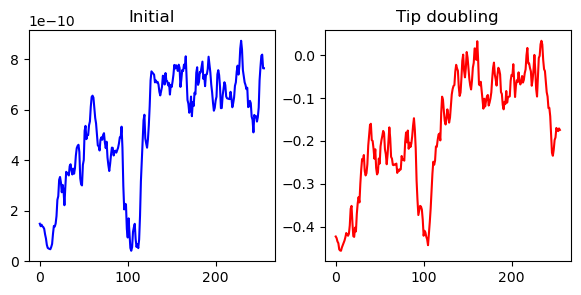

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))

ax[0].plot(line[0], color='b')
ax[0].set_title('Initial')
ax[1].plot(line1[0], color='r')
ax[1].set_title('Tip doubling')

### Non-perfect PI coefficients

> **Note:** In an AR interface, the user typically only has control over the **I coefficient**, while the **P** and **D** coefficients are set to 0. The parameter `dz` specifies the distance between the tip and the surface, simulating tapping mode.

In [52]:
kwargs_low_I = {'I': 0.5, 'dz':5e-9, 'sample_rate': 2000}
kwargs_high_I = {'I': 30, 'dz':5e-9, 'sample_rate': 2000}
kwargs_normal_I = {'I': 10, 'dz':5e-9, 'sample_rate': 2000}


In [53]:
dat =  m.get_scan(channels=['HeightRetrace',], modification=None)

mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_normal_I},]
dat_norm =  m.get_scan(channels=['HeightRetrace',], modification=mod_dict)

mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_low_I},]
dat_low =  m.get_scan(channels=['HeightRetrace',], modification=mod_dict)

mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_high_I},]
dat_high =  m.get_scan(channels=['HeightRetrace',], modification=mod_dict)

dat_high.shape

(1, 256, 256)

Text(0.5, 1.0, 'High I coefficient')

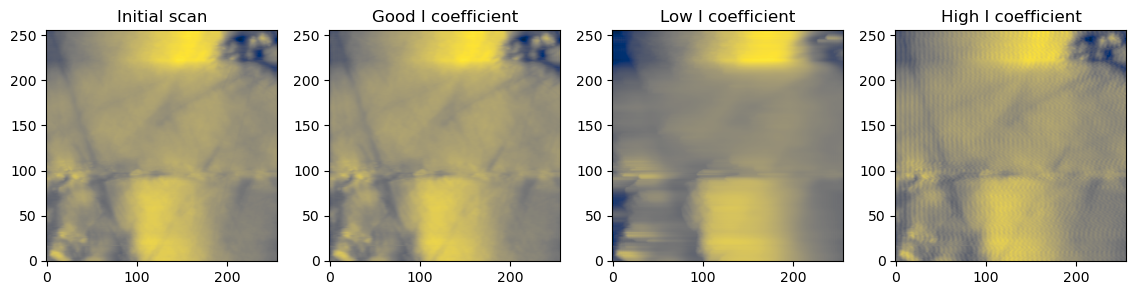

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(14,3))

ax[0].imshow(dat[0].T, cmap='cividis', origin='lower')
ax[0].set_title('Initial scan')
ax[1].imshow(dat_norm[0].T, cmap='cividis', origin='lower')
ax[1].set_title('Good I coefficient')
ax[2].imshow(dat_low[0].T, cmap='cividis', origin='lower')
ax[2].set_title('Low I coefficient')
ax[3].imshow(dat_high[0].T, cmap='cividis', origin='lower')
ax[3].set_title('High I coefficient')

In [55]:
line =  m.scan_individual_line('vertical', channels=['HeightRetrace'], coord = -1e-6, modification=None, trace='forward')
mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_low_I},]
line1 =  m.scan_individual_line('vertical', channels=['HeightRetrace'],coord = -1e-6, modification=mod_dict, trace='backward')
mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_high_I},]
line2 =  m.scan_individual_line('vertical', channels=['HeightRetrace'],coord = -1e-6, modification=mod_dict)
mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_normal_I},]
line3 =  m.scan_individual_line('vertical', channels=['HeightRetrace'],coord = -1e-6, modification=mod_dict)
line1.shape

(1, 256)

Text(0.5, 1.0, 'High I coefficient')

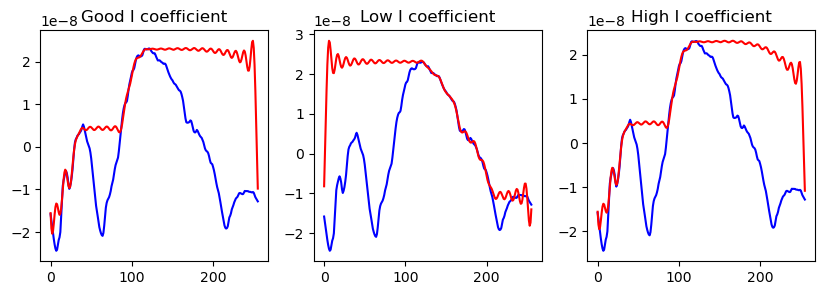

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))


ax[0].plot(line[0], color='b')
ax[0].plot(line3[0], color='r')
ax[0].set_title('Good I coefficient')

ax[1].plot(line[0], color='b')
ax[1].plot(line1[0], color='r')
ax[1].set_title('Low I coefficient')

ax[2].plot(line[0], color='b')
ax[2].plot(line2[0], color='r')
ax[2].set_title('High I coefficient')


In [ ]:
corners = np.array([[-2e-6,2e-6],[1e-6,1.8e-6],[2.1e-6,-1e-6]]) #real coordinates
dat = m.get_scan(channels=['HeightRetrace',])

plt.imshow(dat[0].T, origin='lower', extent=(m.x_min, m.x_max, m.y_min, m.y_max), cmap='cividis')
plt.scatter(corners[:,0], corners[:,1], color='red')
plt.plot(*corners.T, '--', color='red')

In [ ]:
line = m.scan_arbitrary_path(path_points = corners, channels=['HeightRetrace'])
mod_dict = [{'effect': 'real_PID', 'kwargs': kwargs_low_I},]
line2 = m.scan_arbitrary_path(path_points = corners[:,[1,0]], channels=['HeightRetrace'], modification=mod_dict)

fig = plt.figure(figsize=(6,4))
plt.plot(line[0])
plt.plot(line2[0])